In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score,f1_score
import time
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
from sklearn.svm import SVC
import emoji
from cleantext import clean
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import SVC
import time
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruvinjagoda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruvinjagoda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Sentiment_Data.csv',encoding='ISO-8859-1')

print(df.head())

                                               Tweet Sentiment
0  @_angelica_toy Happy Anniversary!!!....The Day...  Mild_Pos
1  @McfarlaneGlenda Happy Anniversary!!!....The D...  Mild_Pos
2  @thevivafrei @JustinTrudeau Happy Anniversary!...  Mild_Pos
3  @NChartierET Happy Anniversary!!!....The Day t...  Mild_Pos
4  @tabithapeters05 Happy Anniversary!!!....The D...  Mild_Pos


In [3]:
np.sum(df.isnull().any(axis=1))

1

In [4]:
# Remove rows with null values
df.dropna(inplace=True)

In [5]:
df['Sentiment'].nunique()

5

Count the occurrences of each unique sentiment

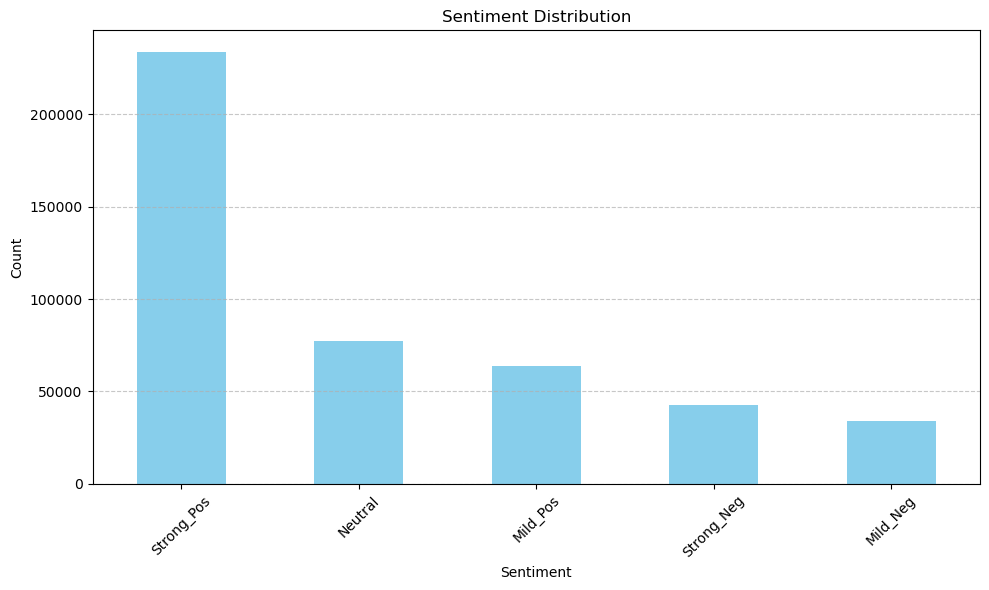

In [6]:


# Count the occurrences of each unique sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Take only 30000 data

In [7]:

# Shuffle the DataFrame to randomize the order of tweets
df_shuffled = df.sample(frac=1, random_state=42)

# Initialize variables to keep track of the number of tweets selected for each category
num_tweets_per_category = 30000 // len(df['Sentiment'].unique())
selected_tweets = []

# Select an equal number of tweets from each category
for sentiment in df_shuffled['Sentiment'].unique():
    tweets_from_category = df_shuffled[df_shuffled['Sentiment'] == sentiment].head(num_tweets_per_category)
    selected_tweets.append(tweets_from_category)

# Concatenate the selected tweets from each category into a single DataFrame
df_selected = pd.concat(selected_tweets)
df = df_selected
df.describe()

Tweet   Sentiment
count                                               30000       30000
unique                                              29998           5
top     @skeeduu @Evry1H8sGrtzLOL @Sinner_Lilith @Lany...  Strong_Neg
freq                                                    2        6000

Remove french tweets

In [8]:
# Function to detect the language of a tweet
def detect_language(tweet):
    try:
        return detect(tweet)
    except:
        return None

# Add a new column 'Language' to the DataFrame containing the detected language of each tweet
df['Language'] = df['Tweet'].apply(detect_language)

# Filter out the tweets that are not in English
df = df[df['Language'] == 'en']

# Display the English tweets
df.describe()

Tweet Sentiment Language
count                                               28750     28750    28750
unique                                              28748         5        1
top     @skeeduu @Evry1H8sGrtzLOL @Sinner_Lilith @Lany...  Mild_Neg       en
freq                                                    2      5904    28750

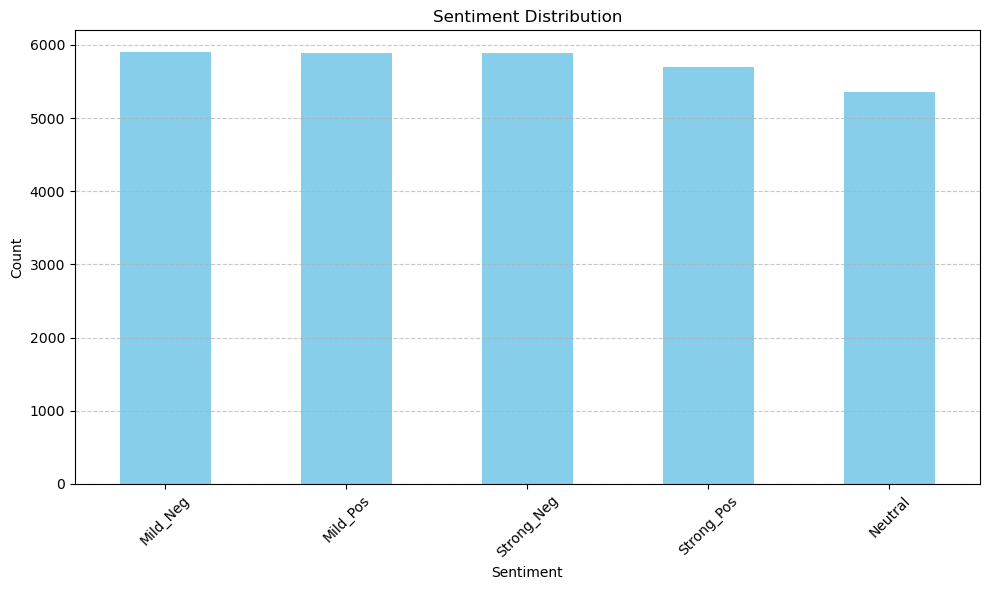

In [9]:
# Count the occurrences of each unique sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Remove mentions and urls as twwets has many of them. Then doing standers preprocessing 

In [10]:
slang_dict = {
    "lol": "laughing out loud",
    "brb": "be right back",
    "toque": "knit hat",
    "loonie": "Canadian one-dollar coin",
    "two-four": "case of 24 beers",
    "Mickey": "375 ml bottle of alcohol",
    "Poutine": "dish of French fries topped with cheese curds and gravy",
    "Double-double": "coffee with two sugars and two creams",
    "Eh": "interjection used to seek confirmation or to express surprise",
    "bae": "significant other",
    "lit": "amazing, exciting",
    "fam": "family or close friends",
    "woke": "socially aware or enlightened",
    "af": "as f*** (emphasis)",
    "thicc": "curvy or voluptuous",
    "flex": "showing off",
    "snack": "attractive person",
    "vibes": "emotional atmosphere or feeling",
    "savage": "fierce or ruthless"
}

# Define a dictionary mapping abbreviations to their full forms
abbrev_dict = {
    "u": "you",
    "r": "are",
    "lol": "laugh out loud",
    "brb": "be right back",
    "btw": "by the way",
    "afaik": "as far as I know",
    "tbh": "to be honest",
    "omg": "oh my god",
    "imho": "in my humble opinion",
    "fyi": "for your information",
    "idk": "I don't know",
    "omw": "on my way",
    "gtg": "got to go",
    "ttyl": "talk to you later",
    "b4": "before",
    "np": "no problem",
    "thx": "thanks",
    "wtf": "what the f***",
    "irl": "in real life",
    "np": "no problem",
    # Add more abbreviations as needed
}



def preprocess_tweet(tweet):
    # Tokenization
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(tweet)
    
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Removing special characters, URLs, and mentions
    tokens = [re.sub(r'http\S+', '', token) for token in tokens]  # Remove URLs
    tokens = [re.sub(r'@[A-Za-z0-9_]+', '', token) for token in tokens]  # Remove mentions
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]  # Remove punctuation
    
    # Handle slang words
    tokens = [slang_dict[token] if token in slang_dict else token for token in tokens]
    
    # Handle abbreviations
    tokens = [abbrev_dict[token] if token in abbrev_dict else token for token in tokens]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# Applying preprocessing to all tweets in the DataFrame
df['Processed_Tweet'] = df['Tweet'].apply(preprocess_tweet)

def remove_emojis(text):
    return clean(text, no_emoji=True)

# Apply the function to remove emojis from the text data
df['Processed_Tweet'] = df['Processed_Tweet'].apply(remove_emojis)


/var/folders/5y/jbjnkkd53qg1b4hcgm4gg0740000gn/T/ipykernel_26501/2033497720.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Processed_Tweet'] = df['Tweet'].apply(preprocess_tweet)
/var/folders/5y/jbjnkkd53qg1b4hcgm4gg0740000gn/T/ipykernel_26501/2033497720.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Processed_Tweet'] = df['Processed_Tweet'].apply(remove_emojis)


In [11]:
df['Tweet'][:1]

/var/folders/5y/jbjnkkd53qg1b4hcgm4gg0740000gn/T/ipykernel_26501/1748349310.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df['Tweet'][:1]


219578    Why would the Emergency Act still be needed if...
Name: Tweet, dtype: object

In [12]:
df['Processed_Tweet'][:1]

/var/folders/5y/jbjnkkd53qg1b4hcgm4gg0740000gn/T/ipykernel_26501/2949898422.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df['Processed_Tweet'][:1]


219578    would emergency act still needed boarder arena...
Name: Processed_Tweet, dtype: object

Ploting most frequent words in unprocessed data

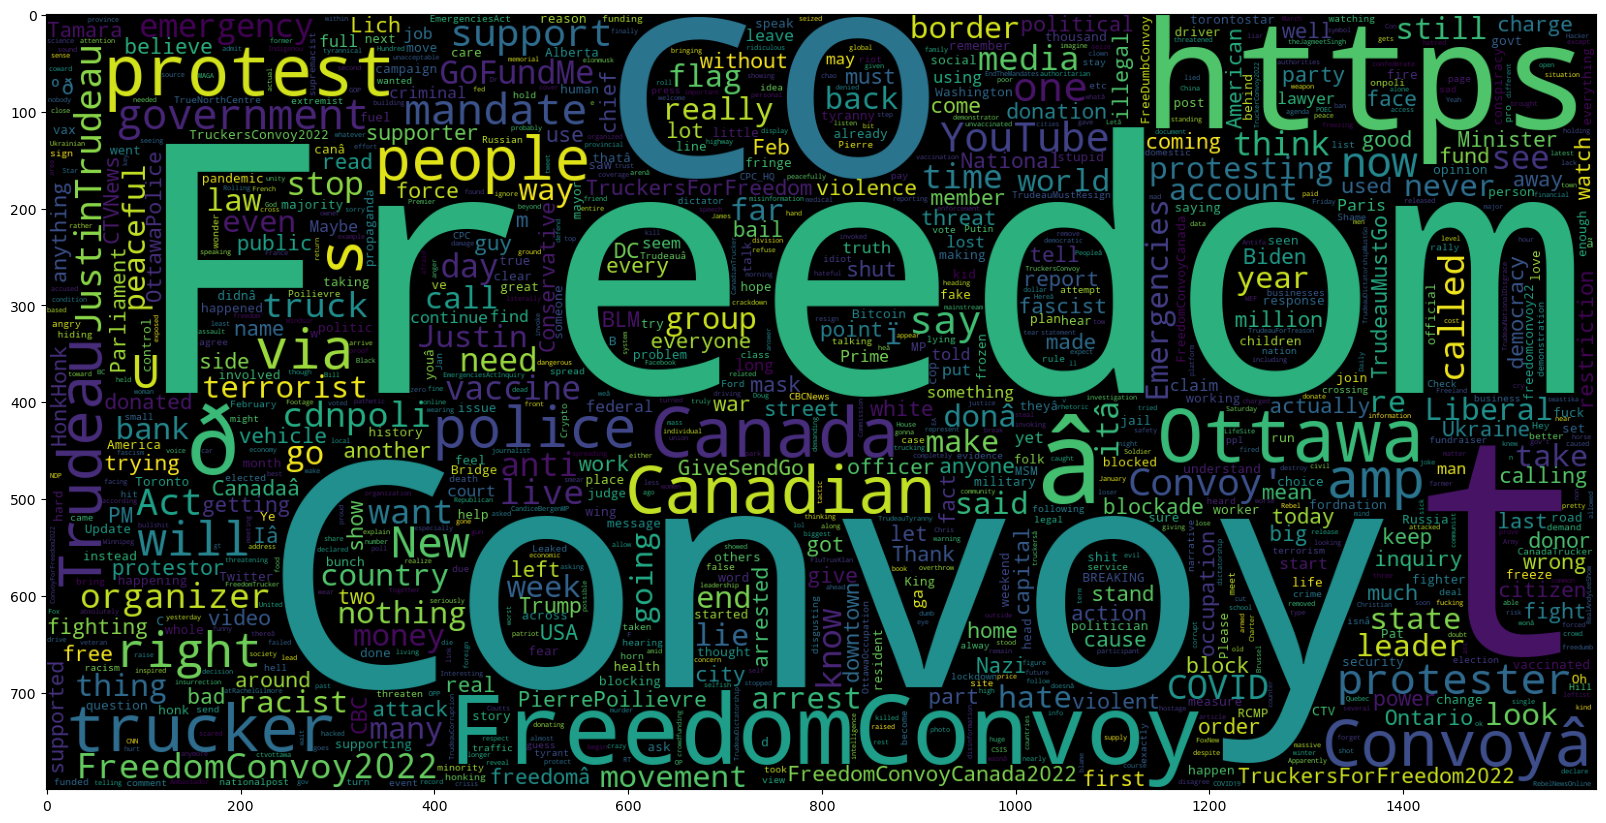

In [13]:

data_neg = df['Tweet']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Frequent words in processed data

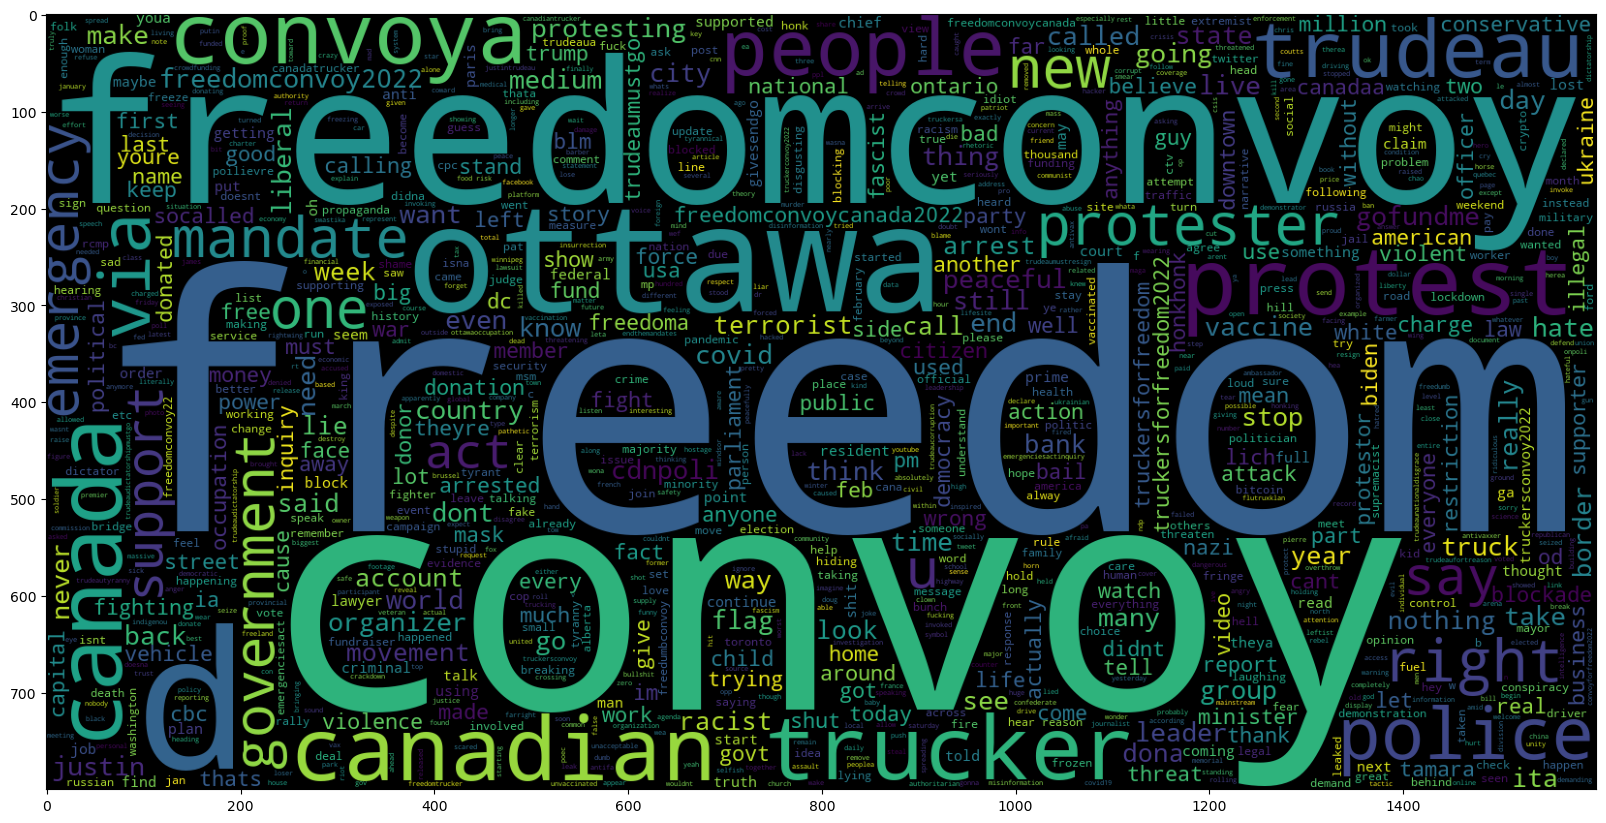

In [14]:
data_neg = df['Processed_Tweet']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Ploting most frequent 10 words in each category

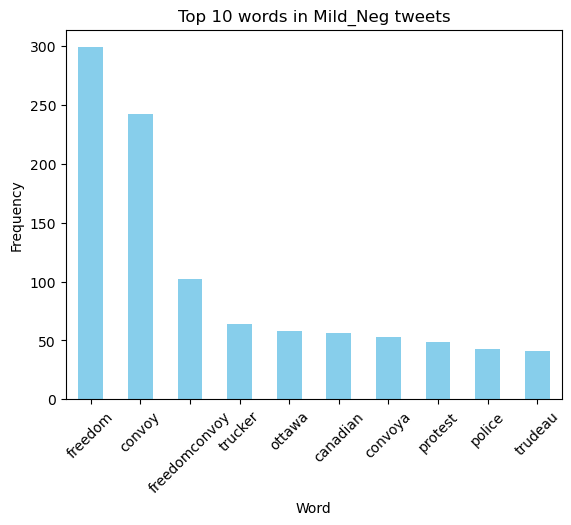

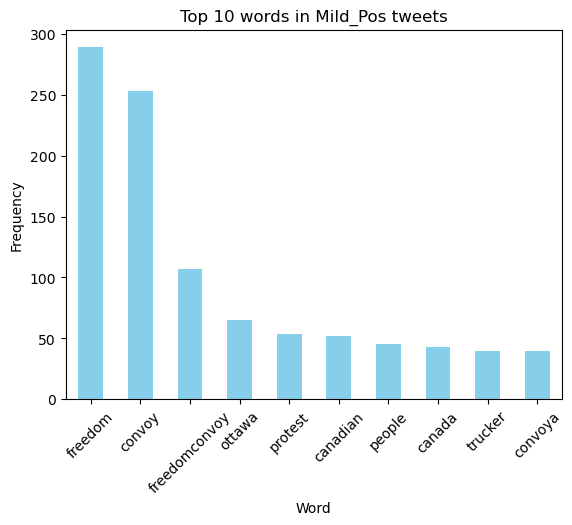

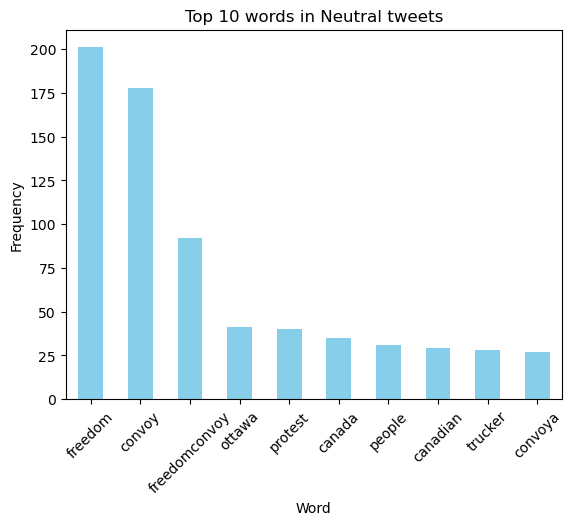

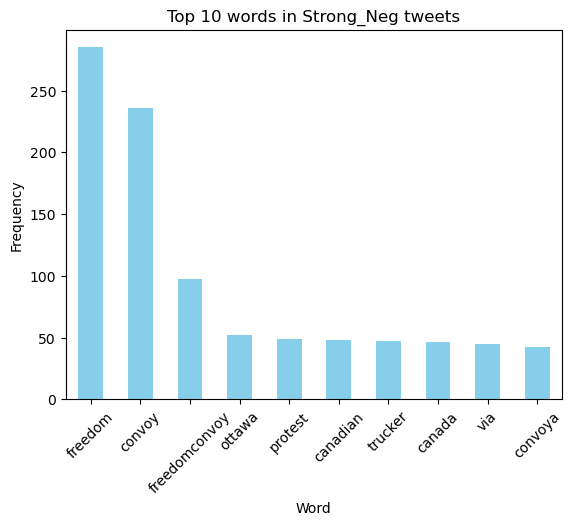

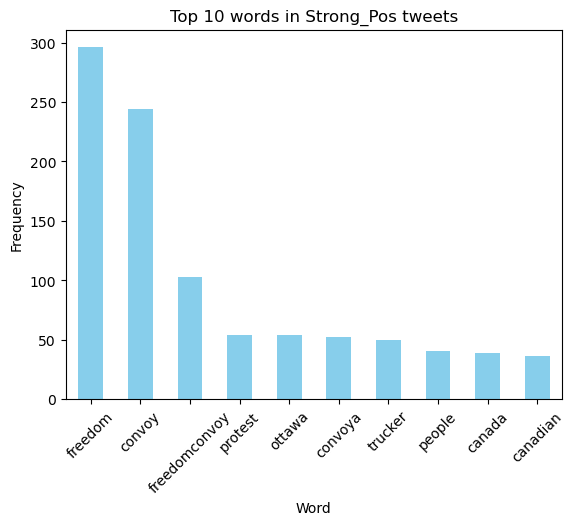

In [15]:

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Processed_Tweet'])

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Add the target labels back to the vectorized data
df_vectorized = pd.DataFrame(X.toarray(), columns=feature_names)
df_vectorized['Sentiment'] = df['Sentiment']

# Group by sentiment and sum the counts for each word
word_counts_by_sentiment = df_vectorized.groupby('Sentiment').sum()

# Get top 10 words with highest frequency for each sentiment
top_words_by_sentiment = {}
for sentiment, counts in word_counts_by_sentiment.iterrows():
    top_words = counts.sort_values(ascending=False).head(10)
    top_words_by_sentiment[sentiment] = top_words

# Plot the top 10 words for each sentiment
for sentiment, top_words in top_words_by_sentiment.items():
    top_words.plot(kind='bar', color='skyblue')
    plt.title(f'Top 10 words in {sentiment} tweets')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

Training set is having more than 5000 data points

In [16]:
# Count the number of items in each class before splitting
class_counts_before_split = df['Sentiment'].value_counts()
print("Class Counts Before Split:\n", class_counts_before_split)

# Split the data into features and target labels
X = df['Processed_Tweet']
y = df['Sentiment']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42678)

# Count the number of items in each class after splitting
class_counts_after_split = y_test.value_counts()
print("\nClass Counts After Split (Training Data):\n", class_counts_after_split)


Class Counts Before Split:
 Mild_Neg      5904
Mild_Pos      5895
Strong_Neg    5892
Strong_Pos    5698
Neutral       5361
Name: Sentiment, dtype: int64

Class Counts After Split (Training Data):
 Mild_Neg      1207
Mild_Pos      1197
Strong_Pos    1154
Strong_Neg    1112
Neutral       1080
Name: Sentiment, dtype: int64


Define the CountVectorizer with unigram features

In [17]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=1000)

# Transform the text data into a bag-of-words representation
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Start training time measurement
start_time = time.time()

# Train the SVM classifier
svm_classifier.fit(X_train_vectorized, y_train)

# End training time measurement
train_time = time.time() - start_time

# Predict on the test data
y_pred = svm_classifier.predict(X_test_vectorized)


Training Data Check

F1 Score for Positive Class on Training Set: [0.54790131 0.7058    ]
F1 Score for Negative Class on Training Set: [0.52921036 0.62103433]
Accuracy on Training Set: 0.598
ROC AUC Score per Class on Training Set: [0.77880751 0.78212312 0.78950708 0.85923845 0.91184984]
Confusion Matrix on Training Set:
[[2565  893  538  280]
 [ 564 3529  176  115]
 [ 536  303 2473  821]
 [ 426  310  855 2858]]


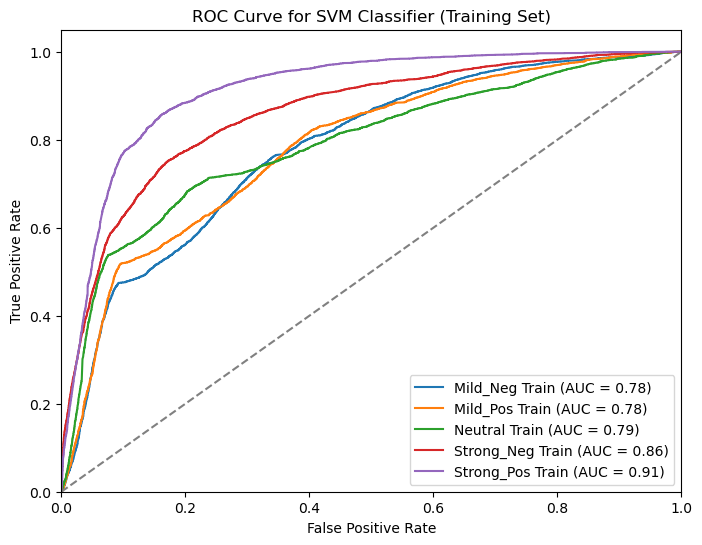

In [18]:
# Calculate F1 score for positive class on training set
f1_score_positive_train = f1_score(y_train, svm_classifier.predict(X_train_vectorized), average=None, labels=['Mild_Pos', 'Strong_Pos'])

# Calculate F1 score for negative class on training set
f1_score_negative_train = f1_score(y_train, svm_classifier.predict(X_train_vectorized), average=None, labels=['Mild_Neg', 'Strong_Neg'])

# Calculate accuracy on training set
accuracy_train = accuracy_score(y_train, svm_classifier.predict(X_train_vectorized))
# Convert labels to binary format
lb = LabelBinarizer()
lb.fit(y_test)
# Convert labels to binary format for training set
y_train_binary = lb.transform(y_train)

# Calculate decision function scores for training set
y_scores_train = svm_classifier.decision_function(X_train_vectorized)

# Convert decision function scores into probabilities for training set
y_scores_proba_train = (y_scores_train - y_scores_train.min()) / (y_scores_train.max() - y_scores_train.min())

# Calculate ROC AUC score for each class on training set
auc_per_class_train = roc_auc_score(y_train_binary, y_scores_proba_train, average=None)

# Calculate confusion matrix for training set
conf_matrix_train = confusion_matrix(y_train, svm_classifier.predict(X_train_vectorized), labels=['Mild_Pos', 'Strong_Pos', 'Mild_Neg', 'Strong_Neg'])

# Print F1 score for positive class on training set
print("F1 Score for Positive Class on Training Set:", f1_score_positive_train)

# Print F1 score for negative class on training set
print("F1 Score for Negative Class on Training Set:", f1_score_negative_train)

# Print accuracy on training set
print("Accuracy on Training Set:", accuracy_train)

# Print ROC AUC score per class on training set
print("ROC AUC Score per Class on Training Set:", auc_per_class_train)

# Print confusion matrix for training set
print("Confusion Matrix on Training Set:")
print(conf_matrix_train)



# Compute ROC curve and ROC area for each class on training set
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i, class_label in enumerate(lb.classes_):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_binary[:, i], y_scores_proba_train[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plot ROC curve for training set
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(lb.classes_):
    plt.plot(fpr_train[i], tpr_train[i], label=f'{class_label} Train (AUC = {roc_auc_train[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier (Training Set)')
plt.legend(loc="lower right")
plt.show()


Check for testing set

Execusion time:  64.57339596748352
F1 Score for Positive Class: [0.44266442 0.63779528]
F1 Score for Negative Class: [0.39313305 0.51116173]
ROC AUC Score per Class: [0.6782992  0.69189171 0.70177829 0.8132114  0.87764594]
Accuracy: 0.49634782608695655
Confusion Matrix:
[[525 270 167 109]
 [205 810  50  42]
 [161 106 458 274]
 [ 96  87 266 561]]


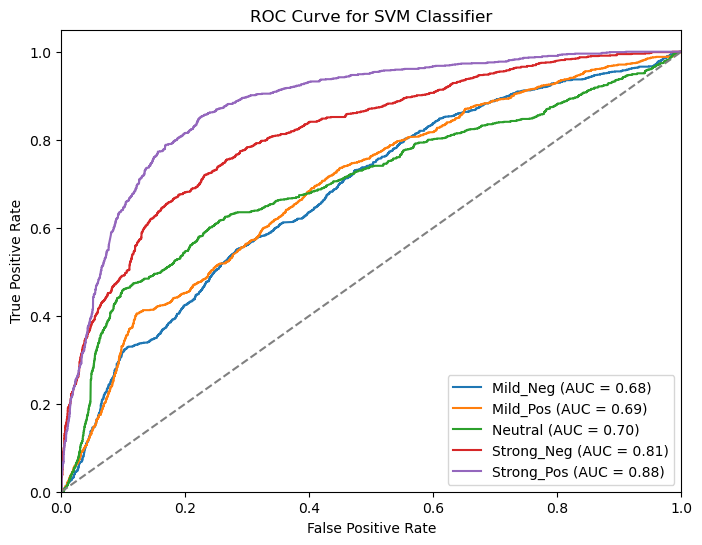

In [19]:


# Calculate F1 score for positive class
f1_score_positive = f1_score(y_test, y_pred, average=None, labels=['Mild_Pos', 'Strong_Pos'])

# Calculate F1 score for negative class
f1_score_negative = f1_score(y_test, y_pred, average=None, labels=['Mild_Neg', 'Strong_Neg'])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Convert labels to binary format
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binary = lb.transform(y_test)

# Calculate decision function scores
y_scores = svm_classifier.decision_function(X_test_vectorized)

# Convert decision function scores into probabilities
y_scores_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

# Calculate ROC AUC score for each class
auc_per_class = roc_auc_score(y_test_binary, y_scores_proba, average=None)

print("Execusion time: ", train_time)
print("F1 Score for Positive Class:", f1_score_positive)
print("F1 Score for Negative Class:", f1_score_negative)
print("ROC AUC Score per Class:", auc_per_class)
print("Accuracy:", accuracy)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=['Mild_Pos', 'Strong_Pos', 'Mild_Neg', 'Strong_Neg'])

print("Confusion Matrix:")
print(conf_matrix)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(lb.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_scores_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(lb.classes_):
    plt.plot(fpr[i], tpr[i], label=f'{class_label} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier')
plt.legend(loc="lower right")
plt.show()

In [20]:
# Get top 2 features added
coef_idx = svm_classifier.coef_.indices
coef_values = svm_classifier.coef_.data
top_features_indices = coef_idx[np.argsort(coef_values)[-5:]]
top_features_names = [feature_names[i] for i in top_features_indices]

top_features_names

['0812', '2yrs', 'abray', 'accent', 'accent']

SVM model using TF-IDF with Unigram+Bigram

In [21]:
# Initialize TF-IDF Vectorizer for unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Transform the text data into TF-IDF representation with unigrams and bigrams
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_test__vectorized = tfidf_vectorizer.transform(X_test)

# Initialize SVM classifier
svm_classifier_tfidf = SVC(kernel='linear')

# Start training time measurement
start_time_svm_tfidf = time.time()

# Train the SVM classifier
svm_classifier_tfidf.fit(X_train_vectorized, y_train)

# End training time measurement
train_time_svm_tfidf = time.time() - start_time_svm_tfidf


Check for training set

F1 Score for Positive Class on Training Set: [0.95940803 0.96321215]
F1 Score for Negative Class on Training Set: [0.95579349 0.96846282]
Accuracy on Training Set: 0.958391304347826
ROC AUC Score per Class on Training Set: [0.9921335  0.99471481 0.99093314 0.99464179 0.99329778]
Confusion Matrix on Training Set:
[[4538   63   42   17]
 [  37 4438   31   15]
 [  48   41 4508   66]
 [  27   43   55 4637]]


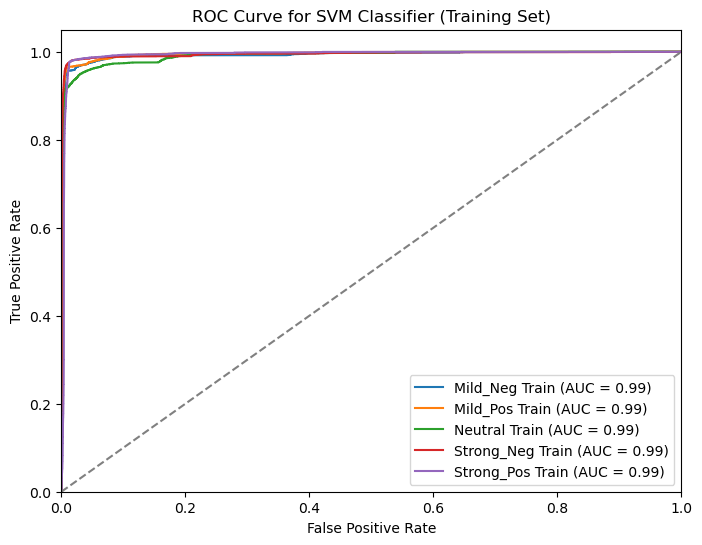

In [22]:
# Calculate F1 score for positive class on training set
f1_score_positive_train = f1_score(y_train, svm_classifier_tfidf.predict(X_train_vectorized), average=None, labels=['Mild_Pos', 'Strong_Pos'])

# Calculate F1 score for negative class on training set
f1_score_negative_train = f1_score(y_train, svm_classifier_tfidf.predict(X_train_vectorized), average=None, labels=['Mild_Neg', 'Strong_Neg'])

# Calculate accuracy on training set
accuracy_train = accuracy_score(y_train, svm_classifier_tfidf.predict(X_train_vectorized))
# Convert labels to binary format
lb = LabelBinarizer()
lb.fit(y_test)
# Convert labels to binary format for training set
y_train_binary = lb.transform(y_train)

# Calculate decision function scores for training set
y_scores_train = svm_classifier_tfidf.decision_function(X_train_vectorized)

# Convert decision function scores into probabilities for training set
y_scores_proba_train = (y_scores_train - y_scores_train.min()) / (y_scores_train.max() - y_scores_train.min())

# Calculate ROC AUC score for each class on training set
auc_per_class_train = roc_auc_score(y_train_binary, y_scores_proba_train, average=None)

# Calculate confusion matrix for training set
conf_matrix_train = confusion_matrix(y_train, svm_classifier_tfidf.predict(X_train_vectorized), labels=['Mild_Pos', 'Strong_Pos', 'Mild_Neg', 'Strong_Neg'])

# Print F1 score for positive class on training set
print("F1 Score for Positive Class on Training Set:", f1_score_positive_train)

# Print F1 score for negative class on training set
print("F1 Score for Negative Class on Training Set:", f1_score_negative_train)

# Print accuracy on training set
print("Accuracy on Training Set:", accuracy_train)

# Print ROC AUC score per class on training set
print("ROC AUC Score per Class on Training Set:", auc_per_class_train)

# Print confusion matrix for training set
print("Confusion Matrix on Training Set:")
print(conf_matrix_train)



# Compute ROC curve and ROC area for each class on training set
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i, class_label in enumerate(lb.classes_):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_binary[:, i], y_scores_proba_train[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plot ROC curve for training set
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(lb.classes_):
    plt.plot(fpr_train[i], tpr_train[i], label=f'{class_label} Train (AUC = {roc_auc_train[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier (Training Set)')
plt.legend(loc="lower right")
plt.show()


Check for test set

              precision    recall  f1-score   support

    Mild_Neg       0.47      0.38      0.42      1207
    Mild_Pos       0.50      0.46      0.48      1197
     Neutral       0.59      0.51      0.55      1080
  Strong_Neg       0.53      0.60      0.56      1112
  Strong_Pos       0.58      0.75      0.65      1154

    accuracy                           0.54      5750
   macro avg       0.53      0.54      0.53      5750
weighted avg       0.53      0.54      0.53      5750

Top 2 Features with Highest Coefficients:
0812
2yrs
abray
accent
accent
Training Time: 123.81573677062988
F1 Score for Positive Class: [0.48233755 0.6523702 ]
F1 Score for Negative Class: [0.41777371 0.56213018]
ROC AUC Score per Class: [0.6782992  0.69189171 0.70177829 0.8132114  0.87764594]
Accuracy: 0.5368695652173913
Top 2 features added: ['0812', '2yrs', 'abray', 'accent', 'accent']


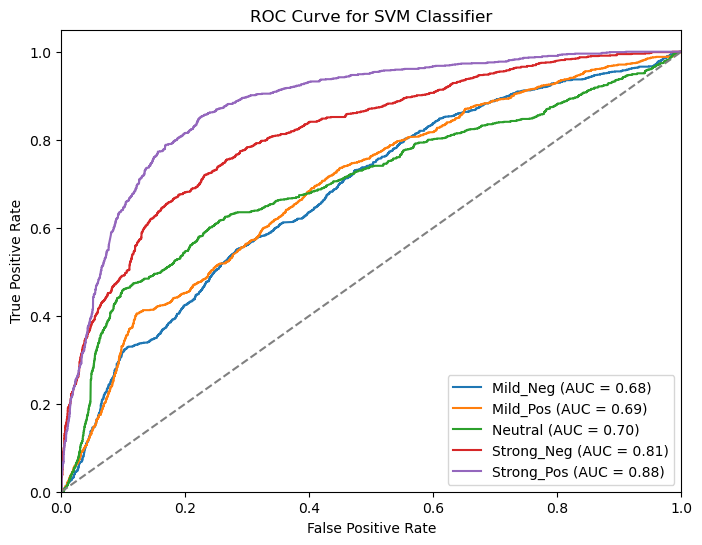

In [23]:
# Predict on the test data
y_pred = svm_classifier_tfidf.predict(X_test__vectorized)



print(classification_report(y_test, y_pred))

# Calculate F1 score for positive class
f1_score_positive = f1_score(y_test, y_pred, average=None, labels=['Mild_Pos', 'Strong_Pos'])

# Calculate F1 score for negative class
f1_score_negative = f1_score(y_test, y_pred, average=None, labels=['Mild_Neg', 'Strong_Neg'])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate AUC
from sklearn.preprocessing import LabelBinarizer

# Convert labels to binary format
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binary = lb.transform(y_test)

# Convert decision function scores into probabilities
y_scores_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

# Calculate ROC AUC score for each class
auc_per_class = roc_auc_score(y_test_binary, y_scores_proba, average=None)

# Get feature names from the TF-IDF vectorizer
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

# Get the indices of the top features based on coefficient values
top_features_indices = np.argsort(coef_values)[-2:]

# Get the names of the top features
#top_features_names = [feature_names_tfidf[i] for i in top_features_indices]

# Print the top feature names
print("Top 2 Features with Highest Coefficients:")
for feature_name in top_features_names:
    print(feature_name)



print("Training Time:", train_time_svm_tfidf)
print("F1 Score for Positive Class:", f1_score_positive)
print("F1 Score for Negative Class:", f1_score_negative)
print("ROC AUC Score per Class:", auc_per_class)
print("Accuracy:", accuracy)
print("Top 2 features added:", top_features_names)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(lb.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_scores_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(lb.classes_):
    plt.plot(fpr[i], tpr[i], label=f'{class_label} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier')
plt.legend(loc="lower right")
plt.show()


Naive Bayes model using One-Hot Vectors for Unigram+Bigram

In [24]:
# Define the CountVectorizer with unigram and bigram features
vectorizer = CountVectorizer(ngram_range=(1, 2), binary=True)

# Transform the text data into one-hot vectors
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize Naive Bayes classifier
nb_classifier = MultinomialNB()

# Start training time measurement
start_time = time.time()

# Train the Naive Bayes classifier
nb_classifier.fit(X_train_vectorized, y_train)

# Predict on the test data
y_pred = nb_classifier.predict(X_test_vectorized)

# End training time measurement
train_time = time.time() - start_time

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Mild_Neg       0.38      0.36      0.37      1207
    Mild_Pos       0.42      0.38      0.40      1197
     Neutral       0.67      0.31      0.43      1080
  Strong_Neg       0.38      0.67      0.49      1112
  Strong_Pos       0.62      0.55      0.58      1154

    accuracy                           0.45      5750
   macro avg       0.49      0.46      0.45      5750
weighted avg       0.49      0.45      0.45      5750



ROC AUC Score per Class on Training Set: [0.99299116 0.99448144 0.99314334 0.9952413  0.99706201]
Confusion Matrix on Training Set:
[[4516   43   68   39]
 [  78 4380   43   22]
 [  65   30 4513   56]
 [  32   37   80 4612]]
F1 Score for Positive Class on Training Set: [0.94804241 0.95790049]
F1 Score for Negative Class on Training Set: [0.94305715 0.95506316]
Accuracy on Training Set: 0.9449565217391305


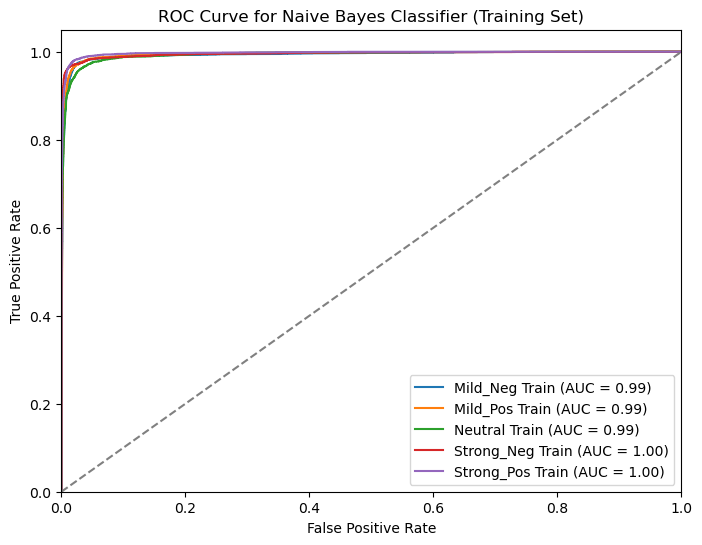

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Predict probabilities on the training set
y_probs_train = nb_classifier.predict_proba(X_train_vectorized)
y_pred_train = nb_classifier.predict(X_train_vectorized)

# Convert labels to binary format for training set
lb = LabelBinarizer()
lb.fit(y_train)
y_train_binary = lb.transform(y_train)
y_pred_train_binary = lb.transform(y_pred_train)

# Calculate ROC AUC score for each class on training set
auc_per_class_train = roc_auc_score(y_train_binary, y_probs_train, average=None)

# Calculate confusion matrix for training set
conf_matrix_train = confusion_matrix(y_train, y_pred_train, labels=['Mild_Pos', 'Strong_Pos', 'Mild_Neg', 'Strong_Neg'])

# Calculate F1 score for positive class on training set
f1_score_positive_train = f1_score(y_train, y_pred_train, average=None, labels=['Mild_Pos', 'Strong_Pos'])

# Calculate F1 score for negative class on training set
f1_score_negative_train = f1_score(y_train, y_pred_train, average=None, labels=['Mild_Neg', 'Strong_Neg'])

# Calculate accuracy on training set
accuracy_train = accuracy_score(y_train, y_pred_train)

# Print ROC AUC score per class on training set
print("ROC AUC Score per Class on Training Set:", auc_per_class_train)

# Print confusion matrix for training set
print("Confusion Matrix on Training Set:")
print(conf_matrix_train)

# Print F1 score for positive class on training set
print("F1 Score for Positive Class on Training Set:", f1_score_positive_train)

# Print F1 score for negative class on training set
print("F1 Score for Negative Class on Training Set:", f1_score_negative_train)

# Print accuracy on training set
print("Accuracy on Training Set:", accuracy_train)

# Compute ROC curve and ROC area for each class on training set
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i, class_label in enumerate(lb.classes_):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_binary[:, i], y_probs_train[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plot ROC curve for training set
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(lb.classes_):
    plt.plot(fpr_train[i], tpr_train[i], label=f'{class_label} Train (AUC = {roc_auc_train[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Classifier (Training Set)')
plt.legend(loc="lower right")
plt.show()


In [26]:


# Calculate F1 score for positive class
f1_score_positive = f1_score(y_test, y_pred, average=None, labels=['Mild_Pos', 'Strong_Pos'])

# Calculate F1 score for negative class
f1_score_negative = f1_score(y_test, y_pred, average=None, labels=['Mild_Neg', 'Strong_Neg'])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate AUC
from sklearn.preprocessing import LabelBinarizer

# Convert labels to binary format
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binary = lb.transform(y_test)

# Convert decision function scores into probabilities
y_scores_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

# Calculate ROC AUC score for each class
auc_per_class = roc_auc_score(y_test_binary, y_scores_proba, average=None)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get the feature names from the CountVectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Get the log probabilities from the learned model
log_probabilities = nb_classifier.feature_log_prob_

# Calculate the log probability differences between classes
log_probability_diffs = log_probabilities[1] - log_probabilities[0]

# Get the indices of the top 2 features
top_indices = np.argsort(log_probability_diffs)[-2:]

# Get the top 2 features
top_features = feature_names[top_indices]



print("Training Time:", train_time)
print("F1 Score for Positive Class:", f1_score_positive)
print("F1 Score for Negative Class:", f1_score_negative)
print("ROC AUC Score per Class:", auc_per_class)
print("Accuracy:", accuracy)
print("Top 2 features added:", top_features)


Training Time: 0.08390998840332031
F1 Score for Positive Class: [0.40139616 0.57957682]
F1 Score for Negative Class: [0.36911328 0.4851229 ]
ROC AUC Score per Class: [0.6782992  0.69189171 0.70177829 0.8132114  0.87764594]
Accuracy: 0.45460869565217393
Top 2 features added: ['medium smear' 'apos']


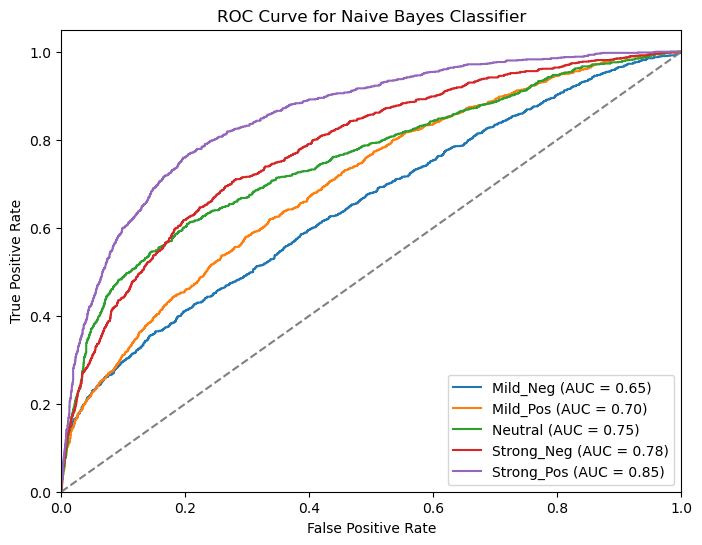

In [27]:
# Calculate the probability estimates for each class
y_prob = nb_classifier.predict_proba(X_test_vectorized)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(nb_classifier.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test == class_label, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(nb_classifier.classes_):
    plt.plot(fpr[i], tpr[i], label=f'{class_label} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Classifier')
plt.legend(loc="lower right")
plt.show()

SVM Model using word2vec (CBOW or Skipgram and any vector size from 64 to 300)

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['Processed_Tweet'], vector_size=100, window=5, min_count=1, workers=4)

# Convert text to word embeddings
X_word2vec = []
for doc in df['Processed_Tweet']:
    doc_embedding = np.zeros(100)  # Initialize with zeros
    count = 0
    for word in doc:
        if word in word2vec_model.wv:
            doc_embedding += word2vec_model.wv[word]
            count += 1
    if count != 0:
        doc_embedding /= count  # Average word vectors
    X_word2vec.append(doc_embedding)
X_word2vec = np.array(X_word2vec)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, df['Sentiment'], test_size=0.2, random_state=42)

# Train SVM model
svm_model = SVC(kernel='linear', probability=True)

# Start training time measurement
start_time = time.time()

svm_model.fit(X_train, y_train)

# End training time measurement
train_time = time.time() - start_time

# Evaluate the model
y_pred = svm_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


              precision    recall  f1-score   support

    Mild_Neg       0.25      0.24      0.25      1136
    Mild_Pos       0.30      0.17      0.22      1232
     Neutral       0.50      0.24      0.33      1071
  Strong_Neg       0.27      0.58      0.37      1155
  Strong_Pos       0.38      0.30      0.34      1156

    accuracy                           0.31      5750
   macro avg       0.34      0.31      0.30      5750
weighted avg       0.34      0.31      0.30      5750

Accuracy: 0.30695652173913046


ROC AUC Score per Class on Training Set: [0.59203542 0.57666664 0.65096793 0.65469567 0.65622638]
Confusion Matrix on Training Set:
[[ 802  698  958 1912]
 [ 619 1285  653 1652]
 [ 589  479 1169 2211]
 [ 404  393  783 2908]]
F1 Score for Positive Class on Training Set: [0.21219738 0.32282377]
F1 Score for Negative Class on Training Set: [0.25731895 0.39323867]
Accuracy on Training Set: 0.31665217391304346


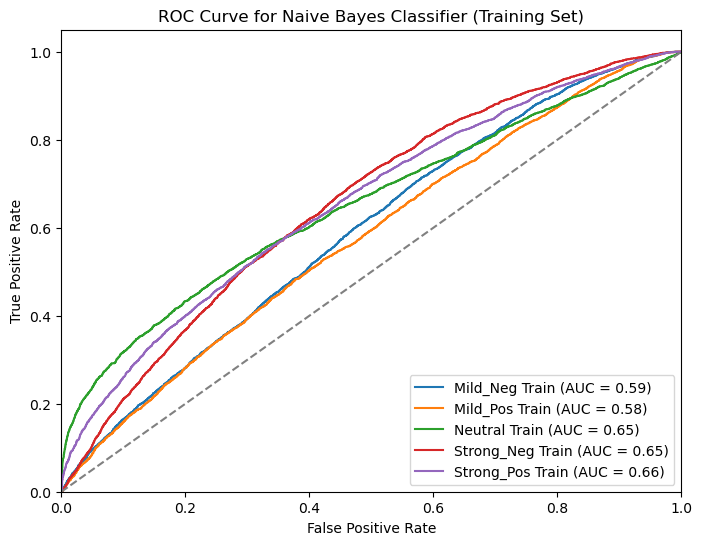

In [29]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Predict probabilities on the training set
y_probs_train = svm_model.predict_proba(X_train)
y_pred_train = svm_model.predict(X_train)

# Convert labels to binary format for training set
lb = LabelBinarizer()
lb.fit(y_train)
y_train_binary = lb.transform(y_train)
y_pred_train_binary = lb.transform(y_pred_train)

# Calculate ROC AUC score for each class on training set
auc_per_class_train = roc_auc_score(y_train_binary, y_probs_train, average=None)

# Calculate confusion matrix for training set
conf_matrix_train = confusion_matrix(y_train, y_pred_train, labels=['Mild_Pos', 'Strong_Pos', 'Mild_Neg', 'Strong_Neg'])

# Calculate F1 score for positive class on training set
f1_score_positive_train = f1_score(y_train, y_pred_train, average=None, labels=['Mild_Pos', 'Strong_Pos'])

# Calculate F1 score for negative class on training set
f1_score_negative_train = f1_score(y_train, y_pred_train, average=None, labels=['Mild_Neg', 'Strong_Neg'])

# Calculate accuracy on training set
accuracy_train = accuracy_score(y_train, y_pred_train)

# Print ROC AUC score per class on training set
print("ROC AUC Score per Class on Training Set:", auc_per_class_train)

# Print confusion matrix for training set
print("Confusion Matrix on Training Set:")
print(conf_matrix_train)

# Print F1 score for positive class on training set
print("F1 Score for Positive Class on Training Set:", f1_score_positive_train)

# Print F1 score for negative class on training set
print("F1 Score for Negative Class on Training Set:", f1_score_negative_train)

# Print accuracy on training set
print("Accuracy on Training Set:", accuracy_train)

# Compute ROC curve and ROC area for each class on training set
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i, class_label in enumerate(lb.classes_):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_binary[:, i], y_probs_train[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plot ROC curve for training set
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(lb.classes_):
    plt.plot(fpr_train[i], tpr_train[i], label=f'{class_label} Train (AUC = {roc_auc_train[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Classifier (Training Set)')
plt.legend(loc="lower right")
plt.show()


In [48]:
# Predictions
y_pred = svm_model.predict(X_test)

# Calculate F1 score for positive class
f1_score_positive = f1_score(y_test, y_pred, average=None, labels=['Mild_Pos', 'Strong_Pos'])

# Calculate F1 score for negative class
f1_score_negative = f1_score(y_test, y_pred, average=None, labels=['Mild_Neg', 'Strong_Neg'])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate AUC
from sklearn.preprocessing import LabelBinarizer

# Convert labels to binary format
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binary = lb.transform(y_test)

# Convert decision function scores into probabilities
y_scores_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

# Calculate ROC AUC score for each class
auc_per_class = roc_auc_score(y_test_binary, y_scores_proba, average=None)


# Get the learned coefficients of the SVM model
coefficients = svm_model.coef_

# Calculate the magnitude of coefficients
magnitude = np.abs(coefficients)

# Get the indices of the top features (words)
top_feature_indices = np.argsort(magnitude)[0][-10:]  # Assuming binary classification, adjust the index if needed

# Get the Word2Vec model's vocabulary
word2vec_vocab = word2vec_model.wv.key_to_index

# Get the top features (words)
top_features = [word for word, index in word2vec_vocab.items() if index in top_feature_indices]

print("Top 10 Important Features:")
for feature in top_features:
    print(feature)
top_features_names = feature_names[top_features_indices]

print("Training Time:", train_time)
print("F1 Score for Positive Class:", f1_score_positive)
print("F1 Score for Negative Class:", f1_score_negative)
print("ROC AUC Score per Class:", auc_per_class)
print("Accuracy:", accuracy)
print("Top 2 features added:", feature_names)


Top 10 Important Features:
Training Time: 731.9177041053772
F1 Score for Positive Class: [0.410277  0.5864726]
F1 Score for Negative Class: [0.36446658 0.51515152]
ROC AUC Score per Class: [0.49315597 0.49329962 0.51455946 0.49767025 0.49595653]
Accuracy: 0.45113043478260867
Top 2 features added: ['the' ',' '.' ... 'rolonda' 'zsombor' 'sandberger']


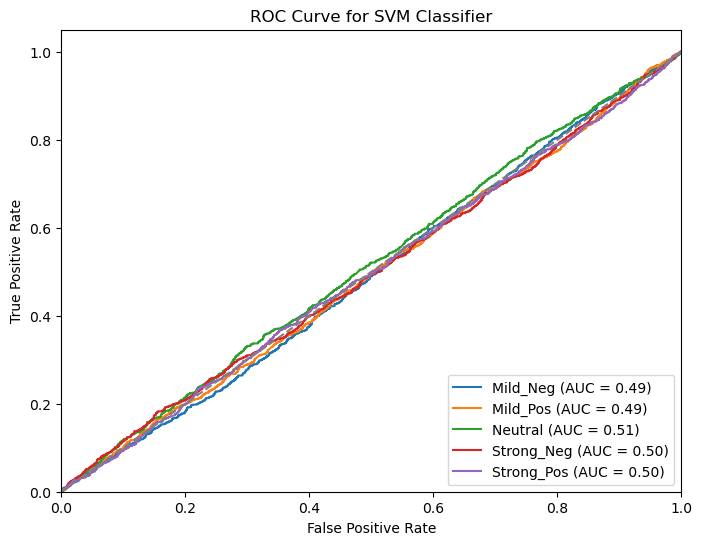

In [31]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(lb.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_scores_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(lb.classes_):
    plt.plot(fpr[i], tpr[i], label=f'{class_label} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier')
plt.legend(loc="lower right")
plt.show()


In [ ]:
SVM Model using any other word embedding (GloVe, Fasttext or ELMo)

In [40]:
import numpy as np
from gensim.models import KeyedVectors
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load GloVe embeddings
glove_file = './glove/glove300d.txt'
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

# Transform text data into embeddings
def document_embedding(doc, model):
    words = doc.split()
    embeddings = []
    for word in words:
        if word in model:
            embeddings.append(model[word])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros_like(model.word_vec("the"))  

# Apply document embedding to each tweet
X = df['Processed_Tweet'].apply(lambda x: document_embedding(x, glove_model))
X = np.vstack(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Sentiment'], test_size=0.2, random_state=42)

# Train SVM model
svm_model = SVC(kernel='linear', probability=True)

# Start training time measurement
start_time = time.time()

svm_model.fit(X_train, y_train)

# End training time measurement
train_time = time.time() - start_time

# Evaluate the model
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))


/var/folders/5y/jbjnkkd53qg1b4hcgm4gg0740000gn/T/ipykernel_26501/867284909.py:21: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return np.zeros_like(model.word_vec("the"))


              precision    recall  f1-score   support

    Mild_Neg       0.34      0.39      0.36      1136
    Mild_Pos       0.41      0.41      0.41      1232
     Neutral       0.46      0.29      0.36      1071
  Strong_Neg       0.48      0.56      0.52      1155
  Strong_Pos       0.58      0.59      0.59      1156

    accuracy                           0.45      5750
   macro avg       0.45      0.45      0.45      5750
weighted avg       0.45      0.45      0.45      5750



ROC AUC Score per Class on Training Set: [0.74089491 0.74169841 0.70927485 0.82922005 0.86100683]
Confusion Matrix on Training Set:
[[2126  861  759  511]
 [1033 2749  290  211]
 [ 672  273 2088 1298]
 [ 409  226 1055 2830]]
F1 Score for Positive Class on Training Set: [0.43866708 0.59670067]
F1 Score for Negative Class on Training Set: [0.42594859 0.55338287]
Accuracy on Training Set: 0.48891304347826087


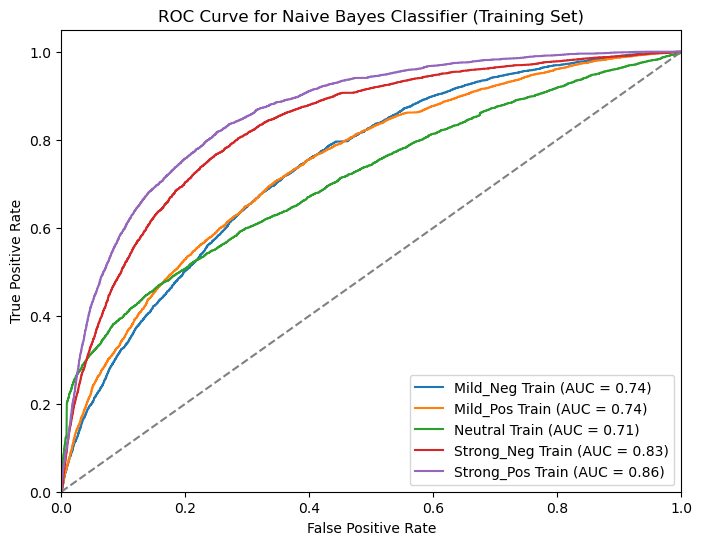

In [41]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Predict probabilities on the training set
y_probs_train = svm_model.predict_proba(X_train)
y_pred_train = svm_model.predict(X_train)

# Convert labels to binary format for training set
lb = LabelBinarizer()
lb.fit(y_train)
y_train_binary = lb.transform(y_train)
y_pred_train_binary = lb.transform(y_pred_train)

# Calculate ROC AUC score for each class on training set
auc_per_class_train = roc_auc_score(y_train_binary, y_probs_train, average=None)

# Calculate confusion matrix for training set
conf_matrix_train = confusion_matrix(y_train, y_pred_train, labels=['Mild_Pos', 'Strong_Pos', 'Mild_Neg', 'Strong_Neg'])

# Calculate F1 score for positive class on training set
f1_score_positive_train = f1_score(y_train, y_pred_train, average=None, labels=['Mild_Pos', 'Strong_Pos'])

# Calculate F1 score for negative class on training set
f1_score_negative_train = f1_score(y_train, y_pred_train, average=None, labels=['Mild_Neg', 'Strong_Neg'])

# Calculate accuracy on training set
accuracy_train = accuracy_score(y_train, y_pred_train)

# Print ROC AUC score per class on training set
print("ROC AUC Score per Class on Training Set:", auc_per_class_train)

# Print confusion matrix for training set
print("Confusion Matrix on Training Set:")
print(conf_matrix_train)

# Print F1 score for positive class on training set
print("F1 Score for Positive Class on Training Set:", f1_score_positive_train)

# Print F1 score for negative class on training set
print("F1 Score for Negative Class on Training Set:", f1_score_negative_train)

# Print accuracy on training set
print("Accuracy on Training Set:", accuracy_train)

# Compute ROC curve and ROC area for each class on training set
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i, class_label in enumerate(lb.classes_):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_binary[:, i], y_probs_train[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plot ROC curve for training set
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(lb.classes_):
    plt.plot(fpr_train[i], tpr_train[i], label=f'{class_label} Train (AUC = {roc_auc_train[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Classifier (Training Set)')
plt.legend(loc="lower right")
plt.show()


[290 193 163  67 197 243 119  91 153 289]
Training Time: 731.9177041053772
F1 Score for Positive Class: [0.410277  0.5864726]
F1 Score for Negative Class: [0.36446658 0.51515152]
ROC AUC Score per Class: [0.49315597 0.49329962 0.51455946 0.49767025 0.49595653]
Accuracy: 0.45113043478260867
Top 2 features added: ['games' 'north' 'home' 'she' 'how' 'based' 'did' 'only' 'part'
 'washington']


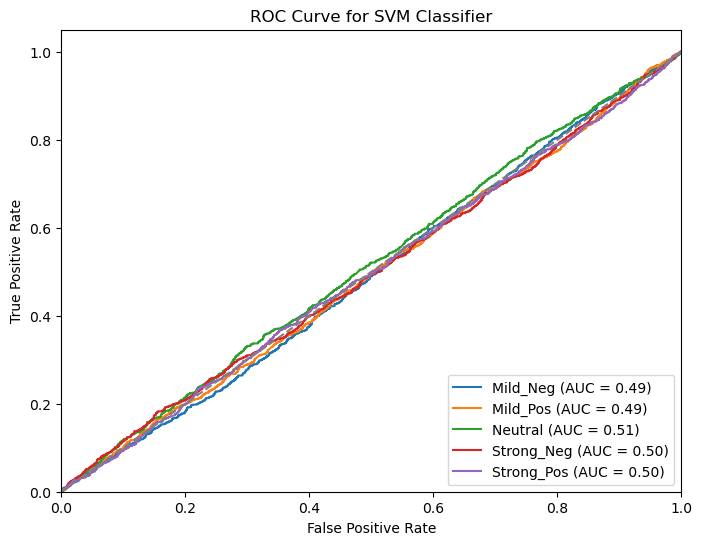

In [46]:
# Predictions
y_pred = svm_model.predict(X_test)

# Calculate F1 score for positive class
f1_score_positive = f1_score(y_test, y_pred, average=None, labels=['Mild_Pos', 'Strong_Pos'])

# Calculate F1 score for negative class
f1_score_negative = f1_score(y_test, y_pred, average=None, labels=['Mild_Neg', 'Strong_Neg'])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate AUC
from sklearn.preprocessing import LabelBinarizer

# Convert labels to binary format
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binary = lb.transform(y_test)

# Convert decision function scores into probabilities
y_scores_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

# Calculate ROC AUC score for each class
auc_per_class = roc_auc_score(y_test_binary, y_scores_proba, average=None)


# Get the feature names
feature_names = np.array(list(glove_model.key_to_index.keys()))
print(top_features_indices)
top_features_names = feature_names[top_features_indices]


print("Training Time:", train_time)
print("F1 Score for Positive Class:", f1_score_positive)
print("F1 Score for Negative Class:", f1_score_negative)
print("ROC AUC Score per Class:", auc_per_class)
print("Accuracy:", accuracy)
print("Top 2 features added:", top_features_names)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(lb.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_scores_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(lb.classes_):
    plt.plot(fpr[i], tpr[i], label=f'{class_label} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier')
plt.legend(loc="lower right")
plt.show()
